<div style="border:2px solid #d9534f, padding: 10px; border-radius:4px;">
<strong>Note on Data</strong><br>
This prototype uses synthetically generated but statistically realistic data to validate system behavior and decision logic.
The objective is scenario simulation and sensitivity analysis, not exact real-world prediction.
The system is designed to directly be used with real tabular datasets (CSV/Excel) without architectural changes in later stages.
</div> 

---
> This files contains the whole code of the project in a well explained manner, _recommended to go through_ if you need to know **what** , **why** and **how** is everything working.

# Objective :
To build an explainable research prototype that simulates realistic agricultural data and studies how environmental and management factors influence crop yield, enabling controlled scenario-based yield analysis.

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from pathlib import Path

---

## 1. Generating synthetic data

Finding the exact real data was not possible using open source so we need to simulate the real life data as close as possible.
- Data will be stored in : `data/syntheticData`

Data we need : **(tabular ONLY)**

| year | rainfall_mm | temperature_c | soil_index | irrigation_pct | fertilizer_kg_ha | pest_pressure_index | yield_kg_ha |
|------|-------------|---------------|------------|----------------|------------------|---------------------|-------------|
| x    | x           | x             | x          | x              | x                | x                   | x           |

- Setting parameters : _(we need random but consistent data)_ 

In [158]:
np.random.seed(123)
years = np.arange(2000,2025)
n_years = len(years)

---

### 1.a Rainfall :

Rainfall has three characteristics :
- High variability year to year
- Long term trends _(can be increasing or decreasing)_
- Occasional extreme years _(droughts/excess rain)_ 
- Physical Boundaries _(cannot be negative)_

We break rainfall into 4 components : `Rainfall = Baseline + Trends + Normal Variability + Rare Shocks`
- Baseline              : Typical rainfall of the region    : `800 mm`
- Trend                 : Slow climate drift over time      : `-3 mm/year`
- Normal variability    : Year to year randomness           : `60 mm`
- Rare shocks           : Drought or extreme rainfall       : `+- 150 mm`

In [159]:
baseline_rainfall = 800

rainfall_trend = -3

normal_variability = np.random.normal( loc=0 , scale=60 , size=n_years )

extreme_events = np.zeros(n_years)
extreme_years = np.random.choice( n_years , size=2 , replace=False )
for i in extreme_years:
    extreme_events[i] = np.random.choice([-150,150])

rainfall_mm = ( baseline_rainfall + (rainfall_trend*(years - years[0])) + normal_variability + extreme_events)

rainfall_mm = np.clip( rainfall_mm , 300 , None )

##### OUTPUT : 

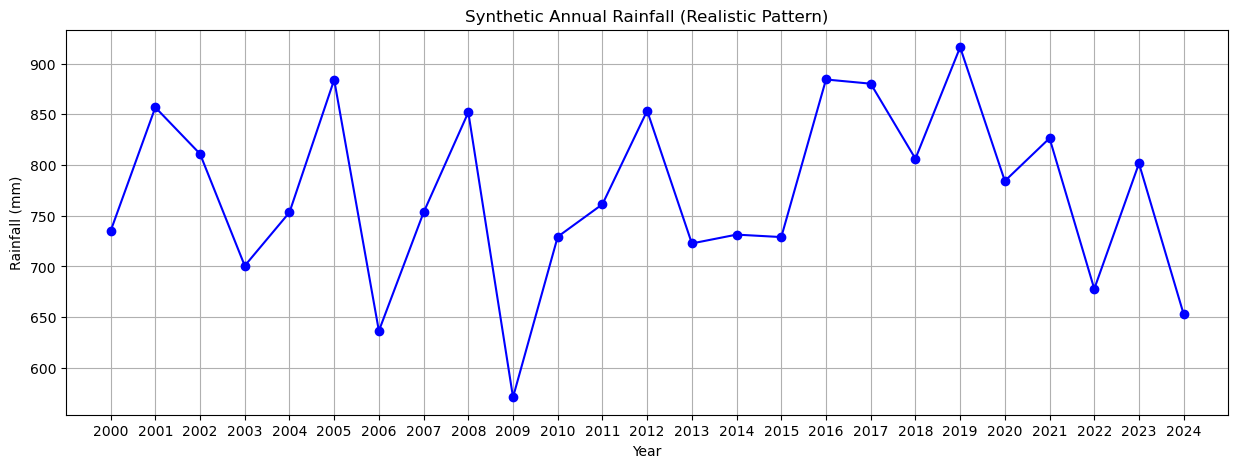

In [160]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2000, 2025))
plt.xlim(1999,2025)
plt.grid(True)

plt.plot(years, rainfall_mm, marker="o", color ="blue")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.title("Synthetic Annual Rainfall (Realistic Pattern)")

plt.show()

---

### 1.b Temperature : 

Temperature has three characteristics :
- Average temperature increases slowly over decades
- Variation year to year is small
- No extreme spikes

We break temperature into 3 components : `Temperature = Baseline + Trends + Natural Noise`
- Baseline          : Typical season average            : `25 degree C`
- Trend             : Climate change warming            : `+ 0.03 degree C per year`
- Noise             : Natural year to year variation    : `0.4 degree C`

In [161]:
baseline_temperature = 25.0
temperature_trends = +0.03
temperature_noise = np.random.normal( loc=0 , scale=0.4 , size=n_years )

temperature_c = (baseline_temperature + (temperature_trends*(years-years[0])) + temperature_noise)

##### OUTPUT : 

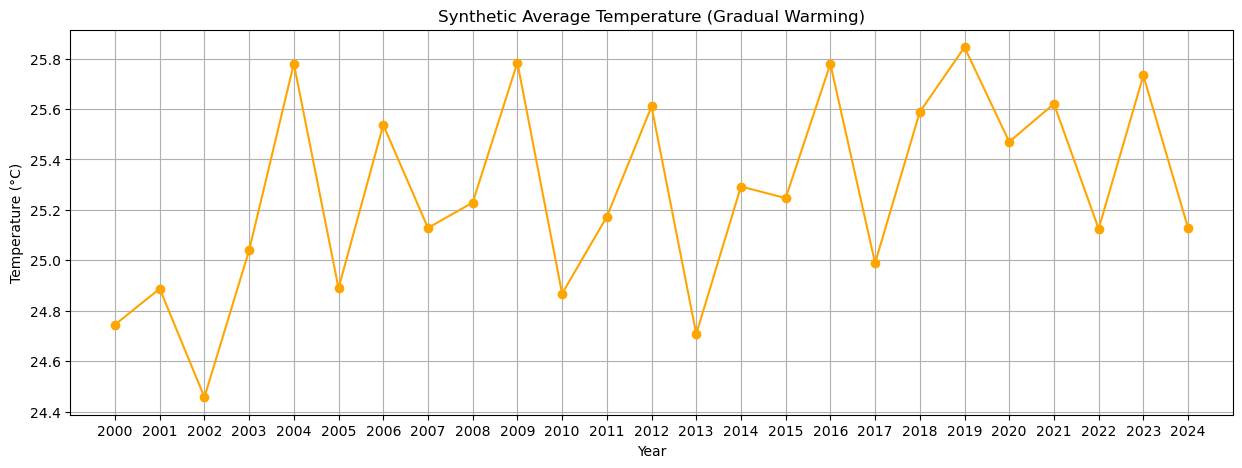

In [162]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2000, 2025))
plt.xlim(1999,2025)
plt.grid(True)

plt.plot(years, temperature_c, marker="o", color="orange")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Synthetic Average Temperature (Gradual Warming)")
plt.show()

---

### 1.c Soil Index :
A composite indicator that represents soil health (nutrient availability,organic carbon,etc)

Soil index has 4 characteristics:
- Changes slowly
- depends on its past state _(recursive)_
- degrade naturally over time
- improve gradually with management 

Design Logic : `soil(i) = soil(i-1) - natural degradation + management improvement + noise`
- Initial soil index        : `0.72`
- Natural degradation       : `-0.003 per year`
- Random variation          : `-0.003 per year`
- Range                     : `0.5 - 0.85`

In [163]:
soil_index = np.zeros(n_years)
soil_index[0] = 0.72

natural_degradation = 0.003
soil_noise = 0.005

for i in range(1, n_years):
    soil_index[i] = (
        soil_index[i - 1]
        - natural_degradation
        + np.random.normal(0, soil_noise)
    )

soil_index = np.clip(soil_index, 0.5, 0.85)

##### OUTPUT : 

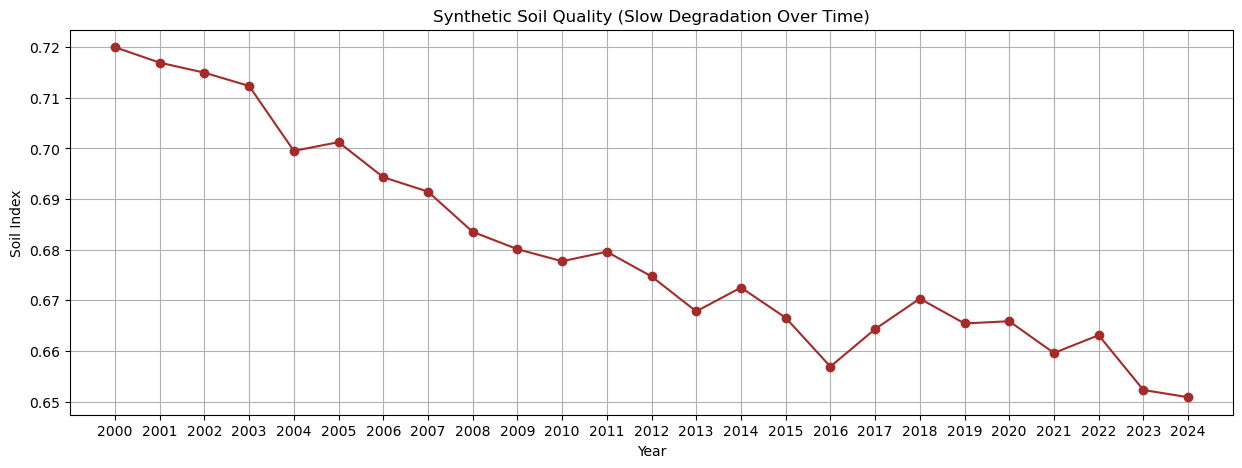

In [164]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2000, 2025))
plt.xlim(1999,2025)
plt.grid(True)

plt.plot(years, soil_index, marker="o", color="brown")
plt.xlabel("Year")
plt.ylabel("Soil Index")
plt.title("Synthetic Soil Quality (Slow Degradation Over Time)")

plt.show()

---

### 1.d Irrigation :
Depends on infrastructure and rainfall (0% irrigation = totally rain feed & 100% irrigation = totally irrigated)
- Realistic boundaries : 30% - 70%

Irrigation has two behaviors :
- Primary : Long term infrastructure growth (dominant)
    - increase slowly over time
    - does not fluctuate over years
- Secondary : Short term rainfall response 
    - drought : more irrigation
    - wet season : less irrigation

Design Logic : `Irrigation(t) = Base Infrastructure Trend + Rainfall Compensation + Small Noise`
- Initial irrigation : `35%`
- Infrastructure growth : `1% per year`
- Rainfall sensitivity : `0.03% per mm deviation`
- Noise : `2%`

In [165]:
base_irrigation = 30.0  
irrigation_trend = 1.0

mean_rainfall = np.mean(rainfall_mm)

rainfall_sensitivity = -0.03  

irrigation_noise = np.random.normal( loc=0 , scale=2.0 , size=n_years )

irrigation_pct = ( base_irrigation + irrigation_trend * (years - years[0]) + rainfall_sensitivity * (rainfall_mm - mean_rainfall) + irrigation_noise )

irrigation_pct = np.clip(irrigation_pct, 30, 70)

##### OUTPUT : 

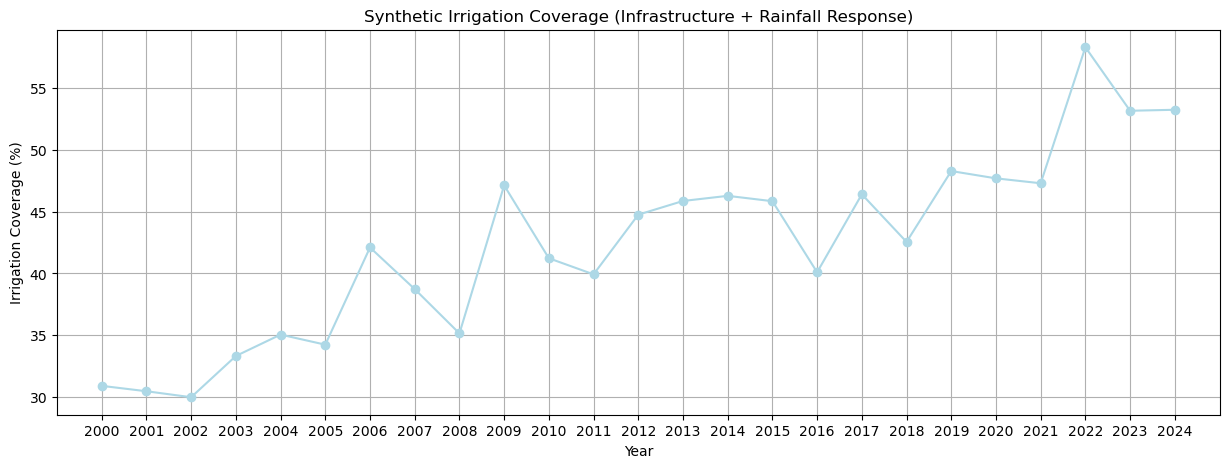

In [166]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2000, 2025))
plt.xlim(1999,2025)
plt.grid(True)

plt.plot(years, irrigation_pct, marker="o", color="lightblue")
plt.xlabel("Year")
plt.ylabel("Irrigation Coverage (%)")
plt.title("Synthetic Irrigation Coverage (Infrastructure + Rainfall Response)")
plt.show()

---

### 1.e Fertilizers :
Average amount of chemical used in per hectare in a year

Fertilizer use trends depends on :
- Infrastructure (dominant) `(positive dependence on irrigation)`
    - Better irrigation : more fertilizer can be used effectively
    - Poor irrigation : efficiency of fertilizer decreases
- Soil Condition `(Inversely dependent on soil quality)`
    - Poor soil : use of fertilizer increases
    - Better soil : fertilizer use balanced
- Noise `random variations`
    - prices, policies, etc
- Long term trend `slow upward graph`
    - gradual inc in use, technology and availability

Design Logic : `Fertilizer(t) = Base level + Irrigation effect + Soil compensation + Trend + Noise `
- Base fertilizer : `80 kg/ha`
- Irrigation sensitivity: `+0.8 kg per % irrigation`
- Soil compensation: `-60 × (soil_index − 0.7)`
- Long-term trend: ` +1.2 kg/ha per year`
- Noise: `10 kg/ha`
- Bound : `Low: 50 kg/ha | High: 200 kg/ha`

In [167]:
base_fertilizer = 80.0

irrigation_effect = 0.8      # kg/ha per % irrigation
soil_compensation = -60.0    # compensate poorer soil
fertilizer_trend = 1.2       # intensification over time

fertilizer_noise = np.random.normal( loc=0, scale=10.0, size=n_years )

fertilizer_kg_ha = ( base_fertilizer + irrigation_effect * irrigation_pct + soil_compensation * (soil_index - 0.7) + fertilizer_trend * (years - years[0]) + fertilizer_noise)

fertilizer_kg_ha = np.clip(fertilizer_kg_ha, 50, 200)

##### OUTPUT : 

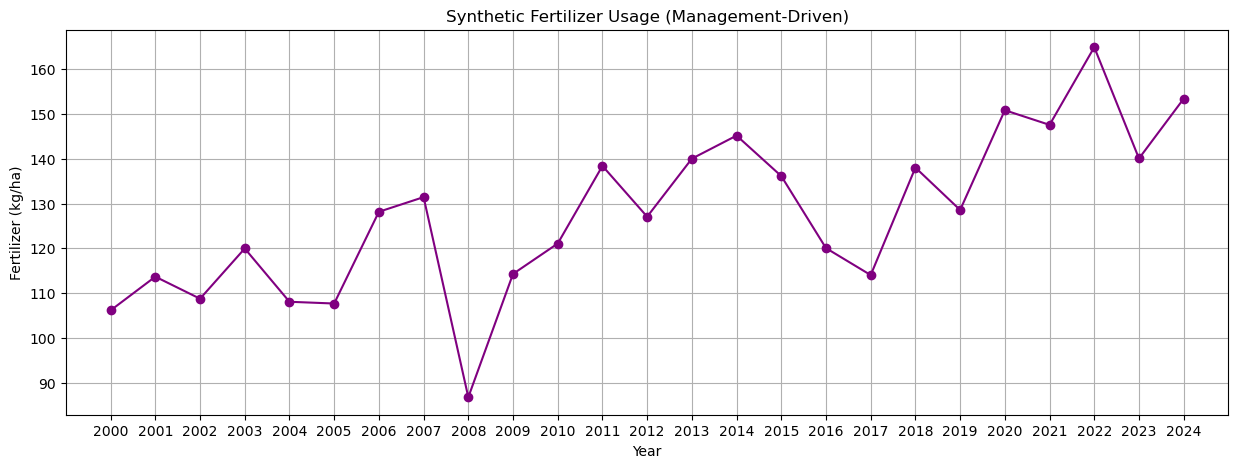

In [168]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2000, 2025))
plt.xlim(1999,2025)
plt.grid(True)

plt.plot(years, fertilizer_kg_ha, marker="o", color="purple")
plt.xlabel("Year")
plt.ylabel("Fertilizer (kg/ha)")
plt.title("Synthetic Fertilizer Usage (Management-Driven)")
plt.show()

---

### 1.f Pest Pressure :

Pest pressure behavior : 
- No long-term trend
- Largely unpredictable
- Sudden spike
- bounded _(cannot exceed total crop failure every year)_

Design logic : `Pest Pressure = Random Baseline + Rare Outbreak Shock`

- Baseline pest pressure: `0.1 to 0.2`
- Outbreak probability: `10% of years`
- Outbreak severity: `+0.4 to +0.6`

| Value | Meaning |
|------|-------------|
| 0.0    | No pest           |
| 0.3    | Mild           |
| 0.6    | Severe           |
| 1.0    | Outbreak           |

In [169]:
pest_pressure = np.random.uniform( low=0.1, high=0.5, size=n_years )

outbreak_years = np.random.choice( n_years, size=3, replace=False )

for i in outbreak_years:
    pest_pressure[i] += np.random.uniform(0.4, 0.6)

pest_pressure_index = np.clip(pest_pressure, 0.0, 1.0)

##### OUTPUT : 

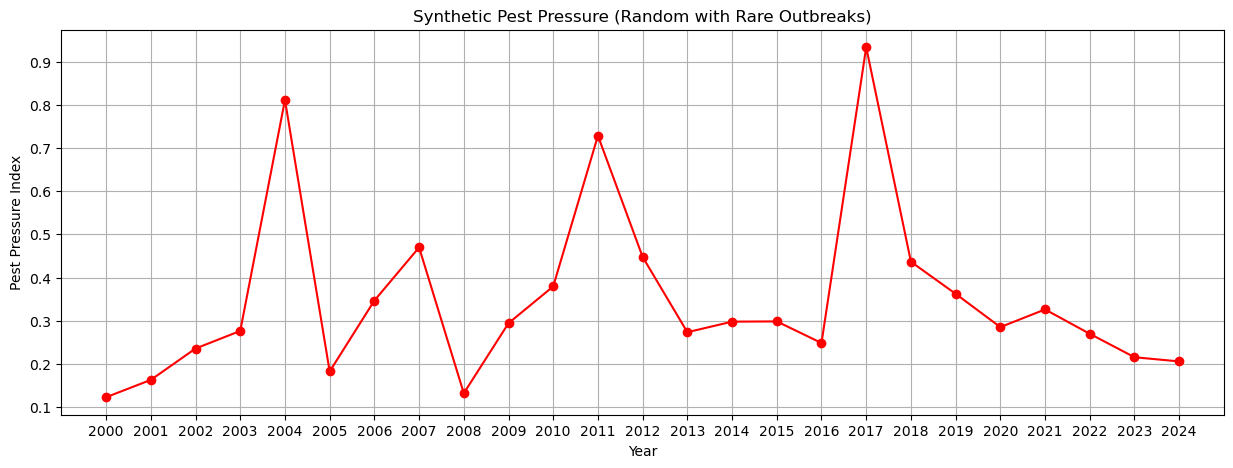

In [170]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2000, 2025))
plt.xlim(1999,2025)
plt.grid(True)

plt.plot(years, pest_pressure_index, marker="o", color="red")
plt.xlabel("Year")
plt.ylabel("Pest Pressure Index")
plt.title("Synthetic Pest Pressure (Random with Rare Outbreaks)")
plt.show()

---

### 1.g Yield : (_important_)
Crop yield (kg/ha) is the final production, after all factors are applied

**Influence by factors** : 
- Positive contributors _(increase yield)_
    - Rainfall 
    - Soil index
    - Irrigation coverage
    - Fertilizer usage
- Negative contributors _(reduce yield)_
    - High temperature 
    - Pest pressure

Using **Linear model** :

`Yield = Base Yield + SUM OF POSITIVE EFFECTS - SUM OF NEGATIVE EFFECTS + noise`

Magnitudes : 
- Base Yield : `2000 kg/ha` 
- Rainfall Effect : `2.5 kg/ha per mm` (for rain feed crop)
- Soil Index Effect: `1200 kg/ha per soil_index unit` (+0.05 soil improvements = +60 kg/ha yield)
- Irrigation Effect : `+15 kg/ha per 1% of irrigation` (+10% irrigation = +150 kg/ha yield)
- Fertilizer Effect : `+3kg/ha per kg fertilizer` (+50 kg\ha fertilizer = +150 kg/ha yield)
- Temperature (heat stress) : `-120 kg/ha deg C above baseline` (baseline = 25 deg C)
- Pest Pressure : `−800 kg/ha × pest_pressure_index` (pest = 0.5 is −400 kg/ha of yield)
- Noise : `Normal(0, 150 kg/ha)` (farmer skill , seed quality , market timing) 

Long-term Yield Stress :

`Yield Stress = λ × (year − start year)`
- Even if farmers increase inputs, the system becomes less efficient over time : `−25 kg/ha per year `

In [171]:
base_yield = 2000

rainfall_coeff = 2.5          # kg/ha per mm
soil_coeff = 1200             # kg/ha per soil index unit
irrigation_coeff = 15         # kg/ha per % irrigation
fertilizer_coeff = 3.0        # kg/ha per kg fertilizer

baseline_temp = 25.0
temperature_coeff = 120     # kg/ha per °C above baseline
pest_coeff = 800            # kg/ha at pest_pressure = 1

yield_noise = np.random.normal( loc=0 , scale=150 , size=n_years )


yield_decline_rate = 15  # kg/ha lost per year due to sustainability stress

system_stress = (
    -yield_decline_rate * (years - years[0])
)

yield_kg_ha = (
    base_yield
    + rainfall_coeff * rainfall_mm
    + soil_coeff * soil_index
    + irrigation_coeff * irrigation_pct
    + fertilizer_coeff * fertilizer_kg_ha
    - temperature_coeff* (temperature_c - baseline_temp)
    - pest_coeff * pest_pressure_index
    + system_stress 
    + yield_noise
)


yield_kg_ha = np.clip(yield_kg_ha, 0, None)

##### OUTPUT : 

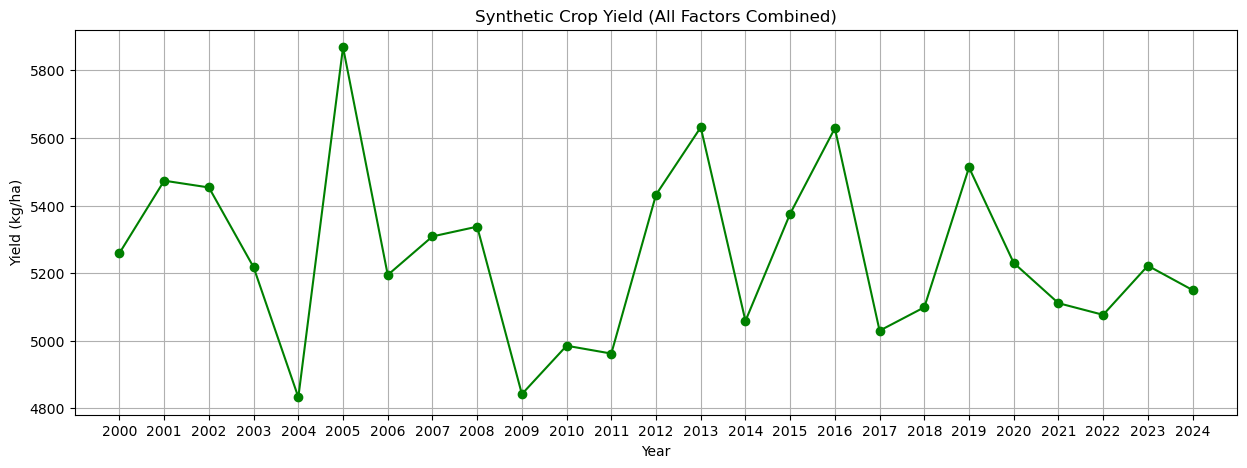

In [172]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2000, 2025))
plt.xlim(1999, 2025)
plt.grid(True)

plt.plot(years, yield_kg_ha, marker="o", color="green")
plt.xlabel("Year")
plt.ylabel("Yield (kg/ha)")
plt.title("Synthetic Crop Yield (All Factors Combined)")
plt.show()

---

## 2. Saving/Extracting the Synthetic Data

### 2.a Creating dataframe :

In [173]:
data = pd.DataFrame({
    "year": years,
    "rainfall_mm": rainfall_mm.round(1),
    "temperature_c": temperature_c.round(2),
    "soil_index": soil_index.round(3),
    "irrigation_pct": irrigation_pct.round(1),
    "fertilizer_kg_ha": fertilizer_kg_ha.round(1),
    "pest_pressure_index": pest_pressure_index.round(2),
    "yield_kg_ha": yield_kg_ha.round(0)
})

data.head()

,year,rainfall_mm,temperature_c,soil_index,irrigation_pct,fertilizer_kg_ha,pest_pressure_index,yield_kg_ha
0,2000,734.9,24.74,0.720,30.9,106.1,0.12,5260.0
1,2001,856.8,24.89,0.717,30.5,113.7,0.16,5474.0
2,2002,811.0,24.46,0.715,30.0,108.7,0.24,5454.0
3,2003,700.6,25.04,0.712,33.3,120.0,0.28,5217.0
4,2004,753.3,25.78,0.700,35.1,108.1,0.81,4833.0


### 2.b Saving Data :

In [174]:
output_path = Path("..") / "data" / "syntheticData" / "universal_synthetic_data.csv"

data.to_csv(output_path, index=False)

print(f"Dataset saved to {output_path}")

Dataset saved to ../data/syntheticData/universal_synthetic_data.csv


### 2.c Extracting Data :

In [175]:
data_path = Path("..") / "data" / "syntheticData" / "universal_synthetic_data.csv"
df = pd.read_csv(data_path)

df.head()

,year,rainfall_mm,temperature_c,soil_index,irrigation_pct,fertilizer_kg_ha,pest_pressure_index,yield_kg_ha
0,2000,734.9,24.74,0.720,30.9,106.1,0.12,5260.0
1,2001,856.8,24.89,0.717,30.5,113.7,0.16,5474.0
2,2002,811.0,24.46,0.715,30.0,108.7,0.24,5454.0
3,2003,700.6,25.04,0.712,33.3,120.0,0.28,5217.0
4,2004,753.3,25.78,0.700,35.1,108.1,0.81,4833.0


---

## 3. Visualizing Data Trends
How the different factors moves relative to each other, while having different units.

To measure all of the factors in one graph they must be scaled to a single unit :

`Z = (X - mean)/standard deviation`

- `0` : historical average
- `+1` : one standard deviation above normal
- `-1` : one standard deviation below normal

### 3.a Creating Standard Scale : 

Variables that we will use as measurements : 
- Rainfall , Temperature , Soil , Irrigation , Fertilizer , Yield

(not _pest pressure_ as that data makes no sense because of its independence)

In [176]:
trend_vars = [ "rainfall_mm", "temperature_c", "soil_index", "irrigation_pct", "fertilizer_kg_ha", "yield_kg_ha" ]

scaler = StandardScaler()

scaled_values = scaler.fit_transform(df[trend_vars])

scaled_df = pd.DataFrame(
    scaled_values,
    columns=trend_vars
)

scaled_df["year"] = df["year"]


### 3.b Plotting the scaled values :

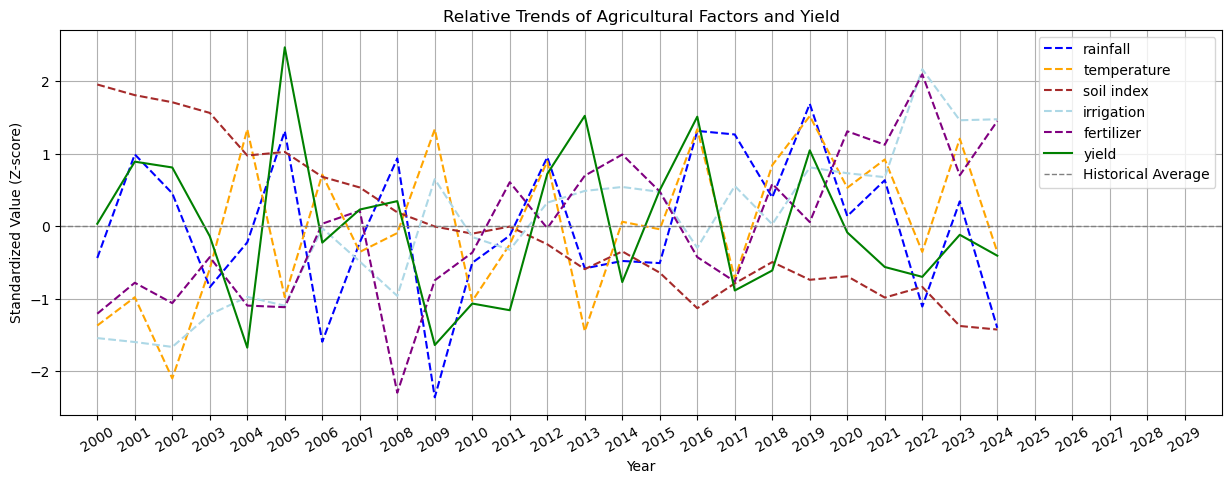

In [177]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2000, 2030), rotation=30)
plt.xlim(1999,2030)
plt.grid(True)

plt.plot(scaled_df["year"], scaled_df["rainfall_mm"] , label = "rainfall" , linestyle = "--" , color = "blue" , )
plt.plot(scaled_df["year"], scaled_df["temperature_c"] , label = "temperature" , linestyle = "--" , color = "orange")
plt.plot(scaled_df["year"], scaled_df["soil_index"] , label = "soil index" , linestyle = "--" , color = "brown")
plt.plot(scaled_df["year"], scaled_df["irrigation_pct"] ,label = "irrigation" , linestyle = "--" ,color = "lightblue")
plt.plot(scaled_df["year"], scaled_df["fertilizer_kg_ha"] ,label = "fertilizer" , linestyle = "--", color = "purple")
plt.plot(scaled_df["year"], scaled_df["yield_kg_ha"] , label = "yield" , color = "green" )

plt.axhline(0, linestyle="--", color="gray", linewidth=1 , label="Historical Average")

plt.xlabel("Year")
plt.ylabel("Standardized Value (Z-score)")
plt.title("Relative Trends of Agricultural Factors and Yield")
plt.legend()
plt.grid(True)

plt.show()


> The standardized trend comparison shows that while management inputs such as irrigation and fertilizer have steadily increased, crop yield does not improve proportionally and instead diverges downward over time, indicating that long-term environmental stress and diminishing system efficiency outweigh input intensification.

---
$$\,\,Data\,\,Analysis...$$

## 4. Regression

> Given the data, can we figure out which factors actually drive yield, and by how much?
---

### Types of regression we will perform : 

- **Raw regression**
    - Real World interpretation : `kg/ha`
- **Standardized regression** 
    - Relative Importance : `%` contribution

### 4.a Raw regression :
- X = explanatory variables (possible causes/factors)
- y = response variables (observed effects)

In [178]:
X = df[[
        "rainfall_mm",
        "temperature_c",
        "soil_index",
        "irrigation_pct",
        "fertilizer_kg_ha",
        "year"
    ]]

y = df["yield_kg_ha"]


Finding the **best coefficient** that makes the equation true on average :
$$
Yield = b_{0} + b_{1}(rainfall) + b_{2}(Temperature) + b_{3}(Soil) + b_{4}(Irrigation) + b_{5}(Fertilizer) + b_{6}(Year)
$$
- `b` is learned sensitivity

In [179]:
raw_model = LinearRegression()
raw_model.fit(X, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


**Raw Coefficient Table :**

In [180]:
raw_coeffs = pd.DataFrame({
    "Factor": X.columns,
    "Impact_on_Yield_kg_per_unit": raw_model.coef_
})

raw_coeffs

,Factor,Impact_on_Yield_kg_per_unit
0,rainfall_mm,2.193763
1,temperature_c,-175.028413
2,soil_index,-7636.067626
3,irrigation_pct,7.926587
4,fertilizer_kg_ha,4.678006
5,year,-38.832521


**OUTPUT :** 
> How much each factor affects the grouth _(assuming all other factors stay the same)_
- Rainfall : ~`+2.2`
    - If rainfall inc by `1 mm`, yield increases by `~ 2.4 kg/ha` 
    - We coded `~ 2.5` (_minor difference_)
- Temperature : ~`-175`
    - If average temperature increases by `1C`, yield decreases by `~ 115 kg/ha`
    - we coded `~ -120` (_strong difference_ : Some long term decline is being absorbed here)
- Soil Index : ~`-7636` _(looks off? Yes it is!!!)_
    - If soil quality increase by `1 unit`(impossible) yield would increase by `~ -7636 kg/ha`
        - Soil Index only moves ~0.01 : $0.01 * 7636 = 7.6 kg/ha$
- Fertilizer : `~ 4.68`
    - We coded `+3` (_fertilizer is related with irrigation so effect is increased_) 
- Year : ~`-39`
    - Even if all the conditions stay constant, yield drops by `~ 39 kg\ha` 

But the value of soil index look **off** WHY?
- `soil index` decreases over time
- `year` decreases over time
- `temperature` increases over time
> Due to strong temporal correlation between **soil degradation**, **climate trends**, and **time**, raw regression coefficient may become unstable. THAT GIVES US THE REASON TO USE **STANDARDIZED MODEL**
---

### 4.b Standardized Regression :
For each variable :
- subtracts its mean,
- divides by its standard

Result:
- Mean = 0
- Standard deviation = 1 (+1 :  unusually high , -1 : unusually low)

> Standardized Regression makes the variables unitless and comparable.

In [181]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # X are the responsible factors

std_model = LinearRegression() # Performing linear regression with the scaled factors
std_model.fit(X_scaled, y) 

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


> How much crop yield (in kg/ha) changes when each factor shifts by a typical historical amount (one standard deviation), assuming all other factors are held constant.

- Yield value is in **kg/ha**
- Inputs are **standardized**
- Yield is are **not standardized**

In [182]:
std_coeffs = pd.DataFrame({
    "Factor": X.columns,
    "Standardized_Impact": std_model.coef_
})

std_coeffs

,Factor,Standardized_Impact
0,rainfall_mm,186.930159
1,temperature_c,-67.183046
2,soil_index,-155.765598
3,irrigation_pct,58.520042
4,fertilizer_kg_ha,83.231956
5,year,-280.025293


**OUTPUT :**

- Rainfall : `~ +187`
    - If rainfall increases by **one standard deviation** (_wetter then normal year_), Yield **increases** by **~ 187 kg/ha**
- Temperature : `~ -67.2`
    - If temperature increases by **one standard deviation** (_hotter then normal year_), Yield **drops** by `~ 67 kg/ha`
- Soil Index : `~ -156`
    - If soil index shifts by **one standard deviation** in the direction it historically moved, Yield changes by `~ 156 kg/ha` in same direction.
    - When the system enters lower soil index region (_which happen later in time_) yield is much lower.
- Irrigation : `~ +59`
    - If irrigation coverage increases by **one standard deviation**, Yield increases by `~ 59kg/ha`
- Fertilizer : `~ +83`
    - If fertilizer usage increases by **one standard deviation**, Yield increases by `~ 83 kg/ha`
    - Fertilizer alone cannot reverse decline
- Year : `- 280`
    - If we move **one standard deviation** forward in time (_several years_), Yield drops by `~280 kg/ha`

> Changes in rainfall have the biggest positive effect on crop yields, while long-term stress over time has the strongest negative impact. Inputs like fertilizer and irrigation help somewhat, but they are not enough to fully make up for ongoing soil and system degradation. Some of the relationships in the model are influenced by how factors change together over time rather than by direct cause-and-effect, which shows that simple linear models have limits when used to explain long-term farming systems.

---

### 4.c Summary of regression :

> How strong is this factor's influence, regarding of whether it helps or hurts yield?

and 

> Out of the total influence exerted bby all factors combined, what percentage comes from each factor?

**Relative explanatory weight inside the linear model.** and rank factors from the most influential to least influential.


In [183]:
std_coeffs["Absolute_Impact"] = std_coeffs["Standardized_Impact"].abs()

std_coeffs["Relative_Contribution (%)"] = (
    std_coeffs["Absolute_Impact"]
    / std_coeffs["Absolute_Impact"].sum()
    * 100
)

std_coeffs.sort_values(
    "Relative_Contribution (%)",
    ascending=False
)

,Factor,Standardized_Impact,Absolute_Impact,Relative_Contribution (%)
5,year,-280.025293,280.025293,33.670804
0,rainfall_mm,186.930159,186.930159,22.476858
2,soil_index,-155.765598,155.765598,18.729568
4,fertilizer_kg_ha,83.231956,83.231956,10.007978
1,temperature_c,-67.183046,67.183046,8.078224
3,irrigation_pct,58.520042,58.520042,7.036567


**OUTPUT :**

> If we break total yield influence into 100 parts, how much parts come from **this** factor?

#### 4.c.1 Visualization 1 :

> Each bar shows how much that factor contributes to overall yield dynamics relative to the others. 

Longer bars indicate stronger influence, regardless of whether the effect is positive or negative.

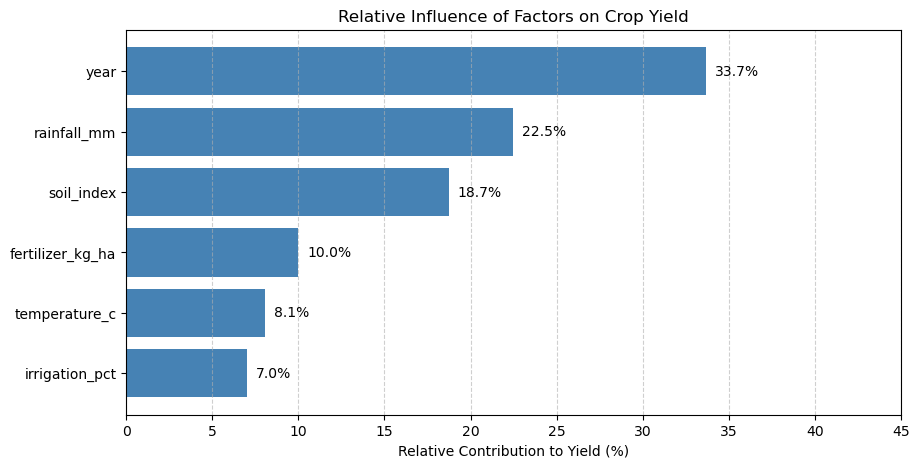

In [184]:
viz_data = std_coeffs.sort_values(
    "Relative_Contribution (%)",
    ascending=True
)

plt.figure(figsize=(10, 5))

plt.barh(
    viz_data["Factor"],
    viz_data["Relative_Contribution (%)"],
    color="steelblue"
)

plt.xlabel("Relative Contribution to Yield (%)")
plt.title("Relative Influence of Factors on Crop Yield")

for i, v in enumerate(viz_data["Relative_Contribution (%)"]):
    plt.text(v + 0.5, i, f"{v:.1f}%", va="center")

plt.xlim(0, 45)
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.show()


**OUTPUT :**
- Year : `33.7%`
    > Almost 35% of the total influence on yield comes from the passage of time itself.
    - Long-term structural decline dominates the system.
- Year : `22.5%`
    > Rainfall results in about one-fifth of total yield influence.
    - Rainfall matters a lot, but it is not enough.
- Soil Index : `18.7%`
    > Soil index contributes 19% of total yield influence.
    - Soil degradation is a key contributor to yield decline.
- Fertilizer : `10%`
    > Fertilizer results in 10% of total yield influence.
    - Fertilizer is a support factor, not a solution.
- Temperature : `8.1%`
    > Temperature contributes ~8% of yield influence.
    - Temperature contributes to decline but is not dominant alone.
- Temperature : `7%`
    > Irrigation results 7% of yield influence.
    - Irrigation helps but is not a grouth factor.

> Most changes in crop yields come from long-term stress on the farming system and from weather and soil conditions. Things farmers can add, like fertilizer and irrigation, play a much smaller role, meaning these inputs alone cannot stop long-term declines in agriculture.

#### 4.c.2 Visualization 2 :

> What **HELPS** vs What **DOES NOT**

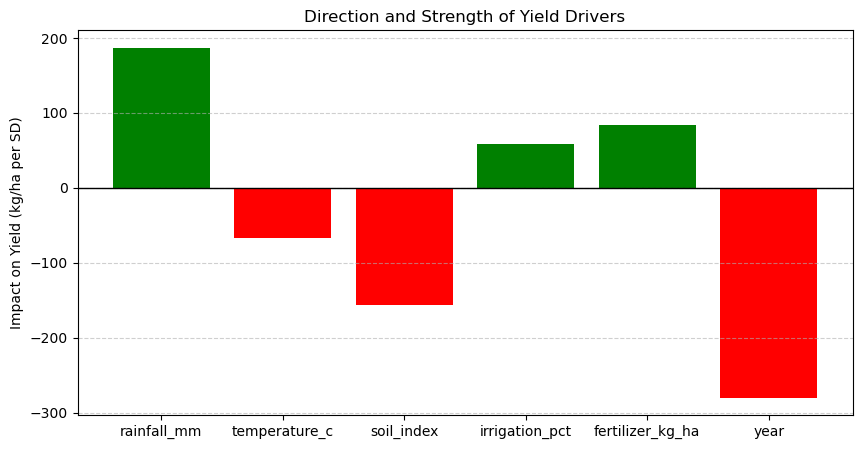

In [185]:
plt.figure(figsize=(10, 5))

colors = [
    "green" if x > 0 else "red"
    for x in std_coeffs["Standardized_Impact"]
]

plt.bar(
    std_coeffs["Factor"],
    std_coeffs["Standardized_Impact"],
    color=colors
)

plt.axhline(0, color="black", linewidth=1)

plt.ylabel("Impact on Yield (kg/ha per SD)")
plt.title("Direction and Strength of Yield Drivers")

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


**OUTPUT :**
> Green bars represent factors that help increase yield, and red bars represent factors that reduce it. The taller the bar, the bigger the impact.

---
$$\,\,Intervention\,\,Analysis...$$

## 5. Scenario Modeling
> Given what we have learned from the past, how can we help the system?

Instead of trying to predict exactly what will happen in the future, this prototype compares how well different intervention options work based on how the system usually behaves.

### 5.a Baseline Future :
> What what happen in future (_10 years_) if nothing changes?

MEANING : Baseline future means -
- **No** new tech
- **No** extra efforts
- **No** optimism
- Rainfall follows historical **climate** trends
- Temperature follows historical **warming** trends
- Soil Index follows historical **degradation** trends
- Irrigation follows historical **infrastructure** trends
- Fertilizer follows historical **infrastructure** trends
- Pest Pressure follow same **randomness** patterns

while time moves forwards

#### 5.a.1 Create Years :
Creates 10 year in future timeline.

In [186]:
future_years = np.arange(years[-1] + 1, years[-1] + 11)
n_future = len(future_years)

#### 5.a.2 Create Factors :
Creates future factor by continuing their historical behavior

In [187]:
baseline_rainfall_future = (
    baseline_rainfall
    + rainfall_trend * (future_years - years[0])
    + np.random.normal(0, 60, n_future)
)
baseline_rainfall_future = np.clip(baseline_rainfall_future, 300, None)

baseline_temperature_future = (
    baseline_temperature
    + temperature_trends * (future_years - years[0])
    + np.random.normal(0, 0.4, n_future)
)

baseline_soil_future = np.zeros(n_future)
baseline_soil_future[0] = soil_index[-1]
for i in range(1, n_future):
    baseline_soil_future[i] = (
        baseline_soil_future[i - 1]
        - natural_degradation
        + np.random.normal(0, soil_noise)
    )
baseline_soil_future = np.clip(baseline_soil_future, 0.5, 0.85)

baseline_irrigation_future = (
    base_irrigation
    + irrigation_trend * (future_years - years[0])
    + rainfall_sensitivity * (baseline_rainfall_future - mean_rainfall)
    + np.random.normal(0, 2.0, n_future)
)
baseline_irrigation_future = np.clip(baseline_irrigation_future, 30, 70)

baseline_fertilizer_future = (
    base_fertilizer
    + irrigation_effect * baseline_irrigation_future
    + soil_compensation * (baseline_soil_future - 0.7)
    + fertilizer_trend * (future_years - years[0])
    + np.random.normal(0, 10.0, n_future)
)
baseline_fertilizer_future = np.clip(baseline_fertilizer_future, 50, 200)

# baseline_pest_future = np.random.uniform(0.1, 0.5, n_future)
# outbreaks = np.random.choice(n_future, size=1, replace=False)
# baseline_pest_future[outbreaks] += np.random.uniform(0.4, 0.6)
# baseline_pest_future = np.clip(baseline_pest_future, 0.0, 1.0)


#### 5.a.3 Learning the Past Data :
We define Causes and Results :
- New **Causes** are not invented,
- The **Causes** defines the amount of yield.

In [188]:
X = df[
    [
        "rainfall_mm",
        "temperature_c",
        "soil_index",
        "irrigation_pct",
        "fertilizer_kg_ha",
        "year",
    ]
]
y = df["yield_kg_ha"]


We standardize the **Causes** : Bringing every factor to _1 unit_

In [189]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Linear Regression : 
- Meaning `Yield = b0 + b1x1 + b2x2 + ... + bnxn`

We assume :
- Effects are additive
- No hidden interactions

We check : Which combination of factors best explains the observed yield yet!
- System _learns_ the pattern and _knows_ how yield reacts.

In [190]:
model = LinearRegression()
model.fit(X_scaled, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


#### 5.a.4 Constructing Baseline Future :
- Creates the baseline data based on the learned trends
- Converts _future values_ into the same standardized unit used during model training.
- The model evaluates the combined effect of all factors
    - returns a **predicted** crop yield

In [191]:
baseline_future = pd.DataFrame({
    "year": future_years,
    "rainfall_mm": baseline_rainfall_future,
    "temperature_c": baseline_temperature_future,
    "soil_index": baseline_soil_future,
    "irrigation_pct": baseline_irrigation_future,
    "fertilizer_kg_ha": baseline_fertilizer_future,
    # "pest_pressure_index": baseline_pest_future
})

baseline_scaled = scaler.transform(
    baseline_future[
        ["rainfall_mm", "temperature_c", "soil_index",
         "irrigation_pct", "fertilizer_kg_ha", "year"]
    ]
)

baseline_future["baseline_yield_kg_ha"] = model.predict(baseline_scaled)


**OUTPUT :**

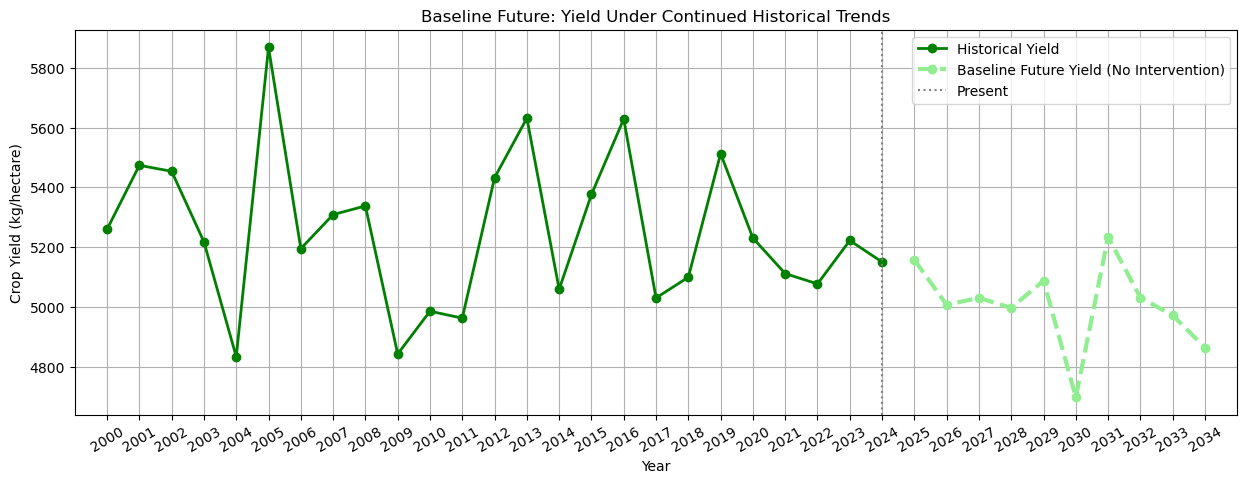

In [192]:
plt.figure(figsize=(15, 5))
plt.xticks(range(2000, 2035), rotation=30)
plt.xlim(1999,2035)
plt.grid(True)

plt.plot(
    years,
    yield_kg_ha,
    label="Historical Yield",
    linewidth=2,
    color = "green",
    marker = "o"
)

plt.plot(
    baseline_future["year"],
    baseline_future["baseline_yield_kg_ha"],
    linestyle="--",
    linewidth=3,
    label="Baseline Future Yield (No Intervention)",
    color = "lightgreen",
    marker = "o"
)

plt.axvline(years[-1], linestyle=":", color="gray", label="Present")

plt.xlabel("Year")
plt.ylabel("Crop Yield (kg/hectare)")
plt.title("Baseline Future: Yield Under Continued Historical Trends")
plt.legend()
plt.grid(True)
plt.show()

> If current trends continue and nothing is done to change them, crop yields will become more **unpredictable** over time, generally **decline**, and occasionally experience years with very **poor harvests**.


---

### 5.b Scenario Interventions :

Simulate interventions by applying sustained annual changes to environmental and management variables, and to observe the effect on crop yield.

- function `run_scenario` : computes future
- function `plot_scenario` : shows future

#### 5.b.1 Calculation Future when an given Factor Changes at a specific rate

What happens if irrigation improves by 2% every year for next 10 years?

In [193]:
def run_scenario(rain_rate=0.0,temp_rate=0.0,soil_rate=0.0,irrigation_rate=0.0,fertilizer_rate=0.0,pest_rate=0.0,):

# creating a copy of baseline to make changes 
    scenario = baseline_future.copy() 

    t = scenario["year"] - scenario["year"].iloc[0] 
# t = [ 0 , 1 , 2 , 3 , 4 , ... ]

    scenario["rainfall_mm"] *= (1 + rain_rate) ** t 
    scenario["temperature_c"] *= (1 + temp_rate) ** t
    scenario["soil_index"] *= (1 - soil_rate) ** t
    scenario["irrigation_pct"] *= (1 + irrigation_rate) ** t
    scenario["fertilizer_kg_ha"] *= (1 + fertilizer_rate) ** t
    # scenario["pest_pressure_index"] *= (1 + pest_rate) ** t
# Example : (same for rest)
# rainfall in 2025 = 800 mm | rain_rate = +0.01 (1%) :
# 2026 = 800 x 1.01
# 2026 = 800 x 1.01^2

# Limiting the values so they stay in realistic zone
    scenario["soil_index"] = scenario["soil_index"].clip(0.5, 0.85)
    scenario["irrigation_pct"] = scenario["irrigation_pct"].clip(30, 70)
    scenario["fertilizer_kg_ha"] = scenario["fertilizer_kg_ha"].clip(50, 200)
    # scenario["pest_pressure_index"] = scenario["pest_pressure_index"].clip(0.0, 1.0)

# Converting Scenario values into the same standardized space (used during training)
    scenario_scaled = scaler.transform(
        scenario[
            [
                "rainfall_mm",
                "temperature_c",
                "soil_index",
                "irrigation_pct",
                "fertilizer_kg_ha",
                "year",
            ]
        ]
    )

# Results the expected yield under this specific intervention trajectory.
    scenario["scenario_yield_kg_ha"] = model.predict(scenario_scaled)

    return scenario
# scenario :
# Future Factors - Applied Interventions - Resulting Yield

> This function models how ongoing, repeated actions affect future conditions over time, and then measures how those changes influence crop yields in the long run based on what the system has learned.

#### 5.b.2 Visual Comparison of Baseline vs Scenario Yield

Visualizing the future we guessed earlier by comparing to past and baseline future. (_on same timeline_)

In [194]:
def plot_scenario(rain_pct=0.0,temp_pct=0.0,soil_pct=0.0,irrigation_pct=0.0,fertilizer_pct=0.0):
    
    # scenario = run_scenario(rain_pct,temp_pct,soil_pct,irrigation_pct,fertilizer_pct,pest_pct)
    scenario = run_scenario(rain_pct,temp_pct,soil_pct,irrigation_pct,fertilizer_pct)

    display(scenario)

    plt.figure(figsize=(15, 5))
    plt.xlim(2000, future_years[-1])
    plt.xticks(range(2000, future_years[-1] + 1, 2))

    plt.plot(years,yield_kg_ha,label="Historical Yield",linewidth=2,color = "green")

    plt.plot(baseline_future["year"],baseline_future["baseline_yield_kg_ha"],linestyle="--",linewidth=3,label="Baseline Future Yield (No Intervention)",color = "lightgreen")

    plt.plot(scenario["year"],scenario["scenario_yield_kg_ha"],linestyle=":",linewidth=3,label="Scenario Yield (With Interventions)",color = "blue")

    plt.axvline(years[-1], linestyle=":", color="gray", label="Present")

    plt.xticks(range(2000, 2035), rotation=30)
    plt.xlim(1999,2035)
    plt.xlabel("Year")
    plt.ylabel("Crop Yield (kg/hectare)")
    plt.title("Scenario Analysis: Yield Response to Factor Changes")
    plt.legend()
    plt.grid(True)
    plt.show()


In [195]:
interact(
    plot_scenario,
    rain_pct=FloatSlider(min=-0.10, max=0.10, step=0.01, value=0.00, description="Rainfall /yr"),
    temp_pct=FloatSlider(min=-0.10, max=0.10, step=0.01, value=0.00, description="Temp /yr"),
    soil_pct=FloatSlider(min=-0.10, max=0.10, step=0.01, value=0.00, description="Soil /yr"),
    irrigation_pct=FloatSlider(min=-0.10, max=0.10, step=0.01, value=0.00, description="Irrigation /yr"),
    fertilizer_pct=FloatSlider(min=-0.10, max=0.10, step=0.01, value=0.00, description="Fertilizer /yr"),
    # pest_pct=FloatSlider(min=-0.10, max=0.10, step=0.01, value=0.00, description="Pest /yr"),
)

interactive(children=(FloatSlider(value=0.0, description='Rainfall /yr', max=0.1, min=-0.1, step=0.01), FloatS…

<function __main__.plot_scenario(rain_pct=0.0, temp_pct=0.0, soil_pct=0.0, irrigation_pct=0.0, fertilizer_pct=0.0)>

> interactive images are not supported in github notebook preview so here is a screenshot :

![screenshot](../outputs/graphs/documentation_notebook_scalar.png) 

---

## Report : 

- ##### [Data Report for Universal Synthetic Data](../outputs/reports/universal_data.pdf)